## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

/Users/carverforbes/internships/google/gunshot-detection/activity-recognition/location/lbs/activity/audioset/dataprocessing


## Call the import statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [2]:
# import statements
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Ran the import statements.


In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'gunshot_30_70'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate'
]
features_to_extract = ['rms']

In [ ]:
# Import the dataset
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, False)

In [6]:
df.head()

,label,rms
0,1,"[[0.024051616, 0.02332899, 0.023757854, 0.0242..."
1,1,"[[0.018282544, 0.018028082, 0.017703537, 0.016..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.04337968, 0.04965238, 0.052755404, 0.05585..."
4,0,"[[0.0066741644, 0.0066920095, 0.0066719446, 0...."


In [7]:
train_df_rms = df.copy()
train_df_rms.head()

,label,rms
0,1,"[[0.024051616, 0.02332899, 0.023757854, 0.0242..."
1,1,"[[0.018282544, 0.018028082, 0.017703537, 0.016..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.04337968, 0.04965238, 0.052755404, 0.05585..."
4,0,"[[0.0066741644, 0.0066920095, 0.0066719446, 0...."


In [8]:
train_df_rms = train_df_rms.reindex(
    np.random.permutation(train_df_rms.index))
train_df_rms.head()

,label,rms
7006,0,"[[0.19823562, 0.19836287, 0.18993057, 0.185059..."
13080,0,"[[0.054777395, 0.05131582, 0.045307025, 0.0398..."
4655,1,"[[0.022201879, 0.023510035, 0.026480392, 0.031..."
19686,0,"[[0.15647826, 0.16522251, 0.17491736, 0.180884..."
19388,0,"[[0.006217517, 0.005825966, 0.0048546395, 0.00..."


In [ ]:
# temp bug fix for rows with None features
# also deletes the outer array in the features
rows_with_none = []
print(train_df_rms.size / 2)
# print(train_df_rms.rms[0])
for i in train_df_rms.index:
    if train_df_rms.rms[i] is None:
        rows_with_none.append(i)
        continue
    train_df_rms.rms[i] = train_df_rms.rms[i][0]
print(rows_with_none)
train_df_rms = train_df_rms.drop(rows_with_none)
train_df_rms.size / 2
train_df_rms.head(10000)

In [10]:
X = np.array(train_df_rms.rms.tolist(), dtype=object)
y = np.array(train_df_rms.label.tolist())

In [11]:
# Temp bug fix for having different sized features
temp_x = []
temp_y = []
count = 0
for arr, label in zip(X, y):
    if arr is None or len(arr) < 431:
#         print('hey look at me', len(arr))
        count += 1
        continue
    temp_x.append(arr)
    temp_y.append(label)
X = np.array(temp_x, dtype=object)
y = np.array(temp_y)
print(count)

1650


In [12]:
# Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics, path, filename, list_of_hyperparameters):
    """Plot a curve of one or more classification metrics vs. epoch and save it to path."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
            
    path = os.path.join(path, filename)
    
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
        
    list_of_hyperparameters_temp = [str(item) for item in list_of_hyperparameters]
    list_of_metrics_temp = [item if isinstance(item, str) else str(item.name) for item in list_of_metrics]
    filename = '_'.join(list_of_metrics_temp) + '_' + '_'.join(list_of_hyperparameters_temp)
    path = os.path.join(path, filename + '.png')
    plt.savefig(path, bbox_inches='tight')
    
    return plt


print("Defined the plot_curve function.")

Defined the plot_curve function.


In [13]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)

In [14]:
# trying to fix bug:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# It worked!!!
from keras import backend as K
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_val = K.cast_to_floatx(x_val)
y_val = K.cast_to_floatx(y_val)

In [15]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

In [16]:
# print(x_train)
print(x_train.shape)

(15540, 431, 1)


## Train 1
Convoluted Neural Network:
* Conv1D Layer 1:
* Flatten Layer 1: 
* Hidden Layer 2: 
* Ouput Layer: 1 node
Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001
* Epochs: 
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: 
* Regularization Lambda: 

In [17]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 10)           440       
_________________________________________________________________
Flatten_1 (Flatten)          (None, 3890)              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 20)                77820     
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 78,281
Trainable params: 78,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
622/622 [==============================] - 4s 6ms/step - loss: 0.5718 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5639 - val_accuracy: 0.7213 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2

Epoch 33/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5174 - accuracy: 0.7413 - precision: 0.7158 - recall: 0.0167 - val_loss: 0.5598 - val_accuracy: 0.7223 - val_precision: 0.5833 - val_recall: 0.0129
Epoch 34/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5177 - accuracy: 0.7411 - precision: 0.6900 - recall: 0.0170 - val_loss: 0.5643 - val_accuracy: 0.7213 - val_precision: 0.5000 - val_recall: 0.0166
Epoch 35/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5179 - accuracy: 0.7418 - precision: 0.6992 - recall: 0.0212 - val_loss: 0.5595 - val_accuracy: 0.7221 - val_precision: 0.5385 - val_recall: 0.0194
Epoch 36/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5162 - accuracy: 0.7417 - precision: 0.7196 - recall: 0.0190 - val_loss: 0.5611 - val_accuracy: 0.7226 - val_precision: 0.5676 - val_recall: 0.0194
Epoch 37/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5165 - accuracy: 0

622/622 [==============================] - 3s 5ms/step - loss: 0.5127 - accuracy: 0.7461 - precision: 0.7500 - recall: 0.0428 - val_loss: 0.5660 - val_accuracy: 0.7244 - val_precision: 0.5769 - val_recall: 0.0416
Epoch 70/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5132 - accuracy: 0.7445 - precision: 0.7177 - recall: 0.0369 - val_loss: 0.5733 - val_accuracy: 0.7226 - val_precision: 0.5490 - val_recall: 0.0259
Epoch 71/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5118 - accuracy: 0.7459 - precision: 0.7557 - recall: 0.0411 - val_loss: 0.5751 - val_accuracy: 0.7216 - val_precision: 0.5067 - val_recall: 0.0351
Epoch 72/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5118 - accuracy: 0.7460 - precision: 0.7545 - recall: 0.0416 - val_loss: 0.5814 - val_accuracy: 0.7216 - val_precision: 0.5094 - val_recall: 0.0249
Epoch 73/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5123 - accuracy: 0.7455 - preci

622/622 [==============================] - 3s 5ms/step - loss: 0.5070 - accuracy: 0.7510 - precision: 0.7455 - recall: 0.0714 - val_loss: 0.5954 - val_accuracy: 0.7244 - val_precision: 0.5500 - val_recall: 0.0609
Epoch 106/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5068 - accuracy: 0.7518 - precision: 0.7537 - recall: 0.0746 - val_loss: 0.5824 - val_accuracy: 0.7277 - val_precision: 0.6050 - val_recall: 0.0665
Epoch 107/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5084 - accuracy: 0.7526 - precision: 0.7660 - recall: 0.0766 - val_loss: 0.5959 - val_accuracy: 0.7277 - val_precision: 0.6016 - val_recall: 0.0683
Epoch 108/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5060 - accuracy: 0.7520 - precision: 0.7518 - recall: 0.0761 - val_loss: 0.5900 - val_accuracy: 0.7277 - val_precision: 0.5786 - val_recall: 0.0849
Epoch 109/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5075 - accuracy: 0.7520 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.5015 - accuracy: 0.7586 - precision: 0.7936 - recall: 0.1032 - val_loss: 0.6076 - val_accuracy: 0.7239 - val_precision: 0.5238 - val_recall: 0.1016
Epoch 142/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5007 - accuracy: 0.7585 - precision: 0.7780 - recall: 0.1061 - val_loss: 0.6174 - val_accuracy: 0.7267 - val_precision: 0.6400 - val_recall: 0.0443
Epoch 143/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5009 - accuracy: 0.7563 - precision: 0.7575 - recall: 0.0992 - val_loss: 0.6029 - val_accuracy: 0.7208 - val_precision: 0.4963 - val_recall: 0.1228
Epoch 144/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4999 - accuracy: 0.7610 - precision: 0.8082 - recall: 0.1120 - val_loss: 0.6123 - val_accuracy: 0.7265 - val_precision: 0.5847 - val_recall: 0.0637
Epoch 145/500
622/622 [==============================] - 3s 5ms/step - loss: 0.5014 - accuracy: 0.7584 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.4992 - accuracy: 0.7631 - precision: 0.7850 - recall: 0.1285 - val_loss: 0.6153 - val_accuracy: 0.7180 - val_precision: 0.4767 - val_recall: 0.1228
Epoch 178/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4973 - accuracy: 0.7653 - precision: 0.8068 - recall: 0.1337 - val_loss: 0.6238 - val_accuracy: 0.7265 - val_precision: 0.5704 - val_recall: 0.0748
Epoch 179/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4986 - accuracy: 0.7633 - precision: 0.7933 - recall: 0.1276 - val_loss: 0.6203 - val_accuracy: 0.7180 - val_precision: 0.4673 - val_recall: 0.0859
Epoch 180/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4983 - accuracy: 0.7646 - precision: 0.7985 - recall: 0.1327 - val_loss: 0.6395 - val_accuracy: 0.7203 - val_precision: 0.4778 - val_recall: 0.0397
Epoch 181/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4971 - accuracy: 0.7644 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.4911 - accuracy: 0.7674 - precision: 0.7992 - recall: 0.1470 - val_loss: 0.6512 - val_accuracy: 0.7167 - val_precision: 0.4656 - val_recall: 0.1127
Epoch 214/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4931 - accuracy: 0.7712 - precision: 0.8203 - recall: 0.1596 - val_loss: 0.6482 - val_accuracy: 0.7172 - val_precision: 0.4646 - val_recall: 0.0970
Epoch 215/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4919 - accuracy: 0.7692 - precision: 0.7914 - recall: 0.1588 - val_loss: 0.6609 - val_accuracy: 0.7226 - val_precision: 0.5194 - val_recall: 0.0619
Epoch 216/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4911 - accuracy: 0.7713 - precision: 0.8126 - recall: 0.1623 - val_loss: 0.6524 - val_accuracy: 0.7154 - val_precision: 0.4294 - val_recall: 0.0646
Epoch 217/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4896 - accuracy: 0.7739 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.4849 - accuracy: 0.7780 - precision: 0.8206 - recall: 0.1926 - val_loss: 0.6878 - val_accuracy: 0.7218 - val_precision: 0.5068 - val_recall: 0.0683
Epoch 250/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4845 - accuracy: 0.7774 - precision: 0.8230 - recall: 0.1889 - val_loss: 0.6869 - val_accuracy: 0.7229 - val_precision: 0.5183 - val_recall: 0.0785
Epoch 251/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4844 - accuracy: 0.7769 - precision: 0.8200 - recall: 0.1874 - val_loss: 0.6780 - val_accuracy: 0.7149 - val_precision: 0.4644 - val_recall: 0.1505
Epoch 252/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4845 - accuracy: 0.7764 - precision: 0.8215 - recall: 0.1847 - val_loss: 0.6786 - val_accuracy: 0.7167 - val_precision: 0.4764 - val_recall: 0.1681
Epoch 253/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4829 - accuracy: 0.7779 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.4783 - accuracy: 0.7818 - precision: 0.8190 - recall: 0.2118 - val_loss: 0.6980 - val_accuracy: 0.7172 - val_precision: 0.4818 - val_recall: 0.1958
Epoch 286/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4769 - accuracy: 0.7848 - precision: 0.8392 - recall: 0.2184 - val_loss: 0.6988 - val_accuracy: 0.7146 - val_precision: 0.4596 - val_recall: 0.1367
Epoch 287/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4777 - accuracy: 0.7828 - precision: 0.8317 - recall: 0.2118 - val_loss: 0.7099 - val_accuracy: 0.7203 - val_precision: 0.4905 - val_recall: 0.0951
Epoch 288/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4789 - accuracy: 0.7838 - precision: 0.8324 - recall: 0.2164 - val_loss: 0.6964 - val_accuracy: 0.7172 - val_precision: 0.4730 - val_recall: 0.1293
Epoch 289/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4790 - accuracy: 0.7831 - p

622/622 [==============================] - 3s 6ms/step - loss: 0.4735 - accuracy: 0.7895 - precision: 0.8423 - recall: 0.2393 - val_loss: 0.7257 - val_accuracy: 0.7187 - val_precision: 0.4829 - val_recall: 0.1302
Epoch 322/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4727 - accuracy: 0.7861 - precision: 0.8230 - recall: 0.2312 - val_loss: 0.7289 - val_accuracy: 0.7231 - val_precision: 0.5143 - val_recall: 0.1163
Epoch 323/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4721 - accuracy: 0.7885 - precision: 0.8348 - recall: 0.2376 - val_loss: 0.7416 - val_accuracy: 0.7167 - val_precision: 0.4619 - val_recall: 0.1006
Epoch 324/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4751 - accuracy: 0.7875 - precision: 0.8245 - recall: 0.2371 - val_loss: 0.7160 - val_accuracy: 0.7156 - val_precision: 0.4704 - val_recall: 0.1616
Epoch 325/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4718 - accuracy: 0.7875 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.4683 - accuracy: 0.7938 - precision: 0.8521 - recall: 0.2554 - val_loss: 0.7189 - val_accuracy: 0.7177 - val_precision: 0.4708 - val_recall: 0.1043
Epoch 358/500
622/622 [==============================] - 3s 6ms/step - loss: 0.4690 - accuracy: 0.7926 - precision: 0.8557 - recall: 0.2482 - val_loss: 0.7281 - val_accuracy: 0.7213 - val_precision: 0.5000 - val_recall: 0.1330
Epoch 359/500
622/622 [==============================] - 4s 6ms/step - loss: 0.4693 - accuracy: 0.7905 - precision: 0.8309 - recall: 0.2492 - val_loss: 0.7476 - val_accuracy: 0.7244 - val_precision: 0.5238 - val_recall: 0.1219
Epoch 360/500
622/622 [==============================] - 3s 6ms/step - loss: 0.4670 - accuracy: 0.7934 - precision: 0.8507 - recall: 0.2539 - val_loss: 0.7314 - val_accuracy: 0.7218 - val_precision: 0.5051 - val_recall: 0.0923
Epoch 361/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4670 - accuracy: 0.7919 - p

622/622 [==============================] - 3s 5ms/step - loss: 0.4624 - accuracy: 0.7959 - precision: 0.8487 - recall: 0.2667 - val_loss: 0.7571 - val_accuracy: 0.7177 - val_precision: 0.4764 - val_recall: 0.1302
Epoch 394/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4645 - accuracy: 0.7972 - precision: 0.8515 - recall: 0.2711 - val_loss: 0.7521 - val_accuracy: 0.7229 - val_precision: 0.5104 - val_recall: 0.1357
Epoch 395/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4634 - accuracy: 0.7981 - precision: 0.8591 - recall: 0.2719 - val_loss: 0.7495 - val_accuracy: 0.7231 - val_precision: 0.5174 - val_recall: 0.0960
Epoch 396/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4632 - accuracy: 0.7981 - precision: 0.8547 - recall: 0.2738 - val_loss: 0.7545 - val_accuracy: 0.7177 - val_precision: 0.4839 - val_recall: 0.1948
Epoch 397/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4634 - accuracy: 0.7967 - p

622/622 [==============================] - 4s 6ms/step - loss: 0.4567 - accuracy: 0.8031 - precision: 0.8710 - recall: 0.2893 - val_loss: 0.7806 - val_accuracy: 0.7115 - val_precision: 0.4655 - val_recall: 0.2364
Epoch 430/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4557 - accuracy: 0.8032 - precision: 0.8696 - recall: 0.2906 - val_loss: 0.7996 - val_accuracy: 0.7244 - val_precision: 0.5291 - val_recall: 0.1006
Epoch 431/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4573 - accuracy: 0.8023 - precision: 0.8591 - recall: 0.2913 - val_loss: 0.7639 - val_accuracy: 0.7115 - val_precision: 0.4534 - val_recall: 0.1708
Epoch 432/500
622/622 [==============================] - 4s 6ms/step - loss: 0.4567 - accuracy: 0.8015 - precision: 0.8637 - recall: 0.2856 - val_loss: 0.7768 - val_accuracy: 0.7182 - val_precision: 0.4769 - val_recall: 0.1145
Epoch 433/500
622/622 [==============================] - 4s 6ms/step - loss: 0.4547 - accuracy: 0.8025 - p

622/622 [==============================] - 4s 6ms/step - loss: 0.4529 - accuracy: 0.8084 - precision: 0.8784 - recall: 0.3095 - val_loss: 0.7887 - val_accuracy: 0.7177 - val_precision: 0.4808 - val_recall: 0.1616
Epoch 466/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4521 - accuracy: 0.8071 - precision: 0.8736 - recall: 0.3063 - val_loss: 0.7900 - val_accuracy: 0.7203 - val_precision: 0.4949 - val_recall: 0.1782
Epoch 467/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4487 - accuracy: 0.8077 - precision: 0.8708 - recall: 0.3103 - val_loss: 0.8087 - val_accuracy: 0.7133 - val_precision: 0.4540 - val_recall: 0.1413
Epoch 468/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4504 - accuracy: 0.8080 - precision: 0.8737 - recall: 0.3100 - val_loss: 0.8679 - val_accuracy: 0.7216 - val_precision: 0.5024 - val_recall: 0.0979
Epoch 469/500
622/622 [==============================] - 3s 5ms/step - loss: 0.4501 - accuracy: 0.8066 - p

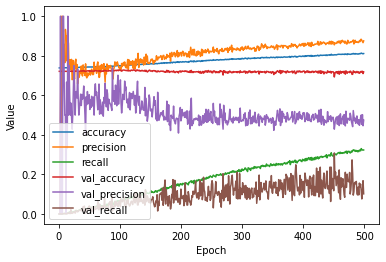

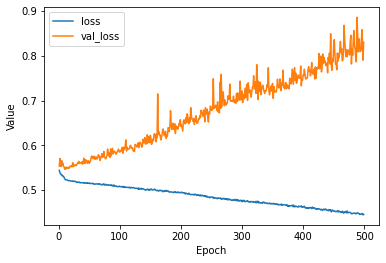

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 500
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot, 'example_dest_dir/training_rms_cnn/', filename, list_of_hyperparameters)
plot_curve(epochs, hist, ['loss', 'val_loss'], 'example_dest_dir/training_rms_cnn/', filename, list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Train 2
Convoluted Neural Network:
* Conv1D Layer 1:
* MaxPooling1D 1:
* Conv1D Layer 1:
* MaxPooling1D 1:
* Flatten Layer 1: 
* Hidden Layer 1: 
* Hidden Layer 2:
* Ouput Layer: 1 node
Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001
* Epochs: 
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: L2
* Regularization Lambda: 

In [21]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=20,
                                           strides=19,
                                           padding='valid',
                                           name='MaxPooling1D_1'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L1 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=100, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))
    
#     # Implement L1 regularization in the second hidden layer.
#     model.add(tf.keras.layers.Dense(units=20, 
#                                   activation='relu',
#                                   kernel_regularizer=tf.keras.regularizers.l1(0.001),
#                                   name='Hidden2'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 5)            220       
_________________________________________________________________
MaxPooling1D_1 (MaxPooling1D (None, 20, 5)             0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
Hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 10,421
Trainable params: 10,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
622/622 [==============================] - 3s 5ms/step - loss: 0.6004 - accuracy: 0.7386 - precision: 0.

Epoch 33/100
622/622 [==============================] - 3s 4ms/step - loss: 0.5031 - accuracy: 0.7539 - precision: 0.7823 - recall: 0.0805 - val_loss: 0.5379 - val_accuracy: 0.7277 - val_precision: 0.7273 - val_recall: 0.0369
Epoch 34/100
622/622 [==============================] - 3s 4ms/step - loss: 0.5023 - accuracy: 0.7545 - precision: 0.7915 - recall: 0.0822 - val_loss: 0.5399 - val_accuracy: 0.7272 - val_precision: 0.7091 - val_recall: 0.0360
Epoch 35/100
622/622 [==============================] - 2s 4ms/step - loss: 0.5017 - accuracy: 0.7541 - precision: 0.7893 - recall: 0.0803 - val_loss: 0.5311 - val_accuracy: 0.7398 - val_precision: 0.7195 - val_recall: 0.1090
Epoch 36/100
622/622 [==============================] - 2s 4ms/step - loss: 0.5001 - accuracy: 0.7560 - precision: 0.8022 - recall: 0.0879 - val_loss: 0.5282 - val_accuracy: 0.7339 - val_precision: 0.7207 - val_recall: 0.0739
Epoch 37/100
622/622 [==============================] - 2s 4ms/step - loss: 0.5001 - accuracy: 0

622/622 [==============================] - 2s 4ms/step - loss: 0.4924 - accuracy: 0.7642 - precision: 0.8056 - recall: 0.1285 - val_loss: 0.5429 - val_accuracy: 0.7385 - val_precision: 0.6650 - val_recall: 0.1247
Epoch 70/100
622/622 [==============================] - 2s 4ms/step - loss: 0.4923 - accuracy: 0.7634 - precision: 0.8060 - recall: 0.1248 - val_loss: 0.5373 - val_accuracy: 0.7347 - val_precision: 0.7281 - val_recall: 0.0766
Epoch 71/100
622/622 [==============================] - 2s 4ms/step - loss: 0.4911 - accuracy: 0.7636 - precision: 0.8146 - recall: 0.1234 - val_loss: 0.5542 - val_accuracy: 0.7434 - val_precision: 0.6229 - val_recall: 0.2013
Epoch 72/100
622/622 [==============================] - 2s 4ms/step - loss: 0.4922 - accuracy: 0.7636 - precision: 0.7936 - recall: 0.1288 - val_loss: 0.5486 - val_accuracy: 0.7383 - val_precision: 0.6364 - val_recall: 0.1422
Epoch 73/100
622/622 [==============================] - 2s 4ms/step - loss: 0.4915 - accuracy: 0.7644 - preci

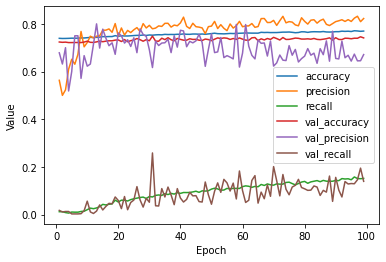

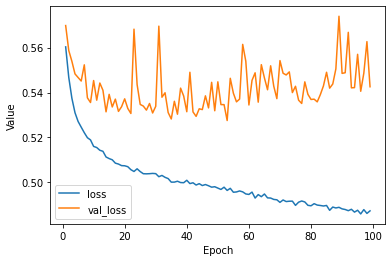

In [22]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
label_name = "label"


# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot, 'example_dest_dir/training_rms_cnn/', filename, list_of_hyperparameters)
plot_curve(epochs, hist, ['loss', 'val_loss'], 'example_dest_dir/training_rms_cnn/', filename, list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Train 3
Convoluted Neural Network:
* Conv1D Layer 1:
* MaxPooling1D 1:
* Conv1D Layer 1:
* MaxPooling1D 1:
* Flatten Layer 1: 
* Hidden Layer 1: 
* Hidden Layer 2:
* Ouput Layer: 1 node
Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001
* Epochs: 
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: L2
* Regularization Lambda: 

In [23]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=20,
                                           strides=19,
                                           padding='valid',
                                           name='MaxPooling1D_1'))
    
    model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=2, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_2'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L1 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=100, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))
    
#     # Implement L1 regularization in the second hidden layer.
#     model.add(tf.keras.layers.Dense(units=20, 
#                                   activation='relu',
#                                   kernel_regularizer=tf.keras.regularizers.l1(0.001),
#                                   name='Hidden2'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 10)           440       
_________________________________________________________________
MaxPooling1D_1 (MaxPooling1D (None, 20, 10)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 19, 1)             21        
_________________________________________________________________
Flatten_1 (Flatten)          (None, 19)                0         
_________________________________________________________________
Hidden1 (Dense)              (None, 100)               2000      
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 2,562
Trainable params: 2,562
Non-trainable params: 0
___________________________________________________

622/622 [==============================] - 4s 6ms/step - loss: 0.5208 - accuracy: 0.7396 - precision: 0.8500 - recall: 0.0042 - val_loss: 0.5398 - val_accuracy: 0.7226 - val_precision: 0.7778 - val_recall: 0.0065
Epoch 33/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5204 - accuracy: 0.7395 - precision: 0.7097 - recall: 0.0054 - val_loss: 0.5378 - val_accuracy: 0.7221 - val_precision: 0.6667 - val_recall: 0.0055
Epoch 34/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5209 - accuracy: 0.7396 - precision: 0.6923 - recall: 0.0066 - val_loss: 0.5383 - val_accuracy: 0.7221 - val_precision: 0.6667 - val_recall: 0.0055
Epoch 35/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5199 - accuracy: 0.7395 - precision: 0.7241 - recall: 0.0052 - val_loss: 0.5417 - val_accuracy: 0.7223 - val_precision: 0.7000 - val_recall: 0.0065
Epoch 36/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5201 - accuracy: 0.7397 - preci

622/622 [==============================] - 4s 6ms/step - loss: 0.5167 - accuracy: 0.7427 - precision: 0.7143 - recall: 0.0259 - val_loss: 0.5544 - val_accuracy: 0.7229 - val_precision: 0.6071 - val_recall: 0.0157
Epoch 69/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5157 - accuracy: 0.7431 - precision: 0.7125 - recall: 0.0281 - val_loss: 0.5562 - val_accuracy: 0.7216 - val_precision: 0.5263 - val_recall: 0.0092
Epoch 70/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5166 - accuracy: 0.7425 - precision: 0.6705 - recall: 0.0291 - val_loss: 0.5378 - val_accuracy: 0.7241 - val_precision: 0.6410 - val_recall: 0.0231
Epoch 71/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5164 - accuracy: 0.7425 - precision: 0.6746 - recall: 0.0281 - val_loss: 0.5374 - val_accuracy: 0.7234 - val_precision: 0.6818 - val_recall: 0.0139
Epoch 72/100
622/622 [==============================] - 4s 6ms/step - loss: 0.5161 - accuracy: 0.7439 - preci

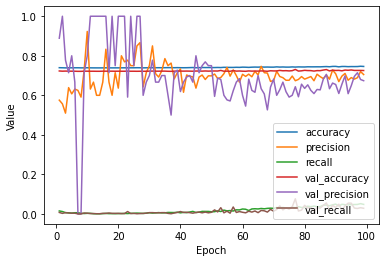

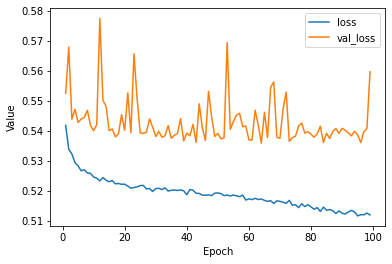

In [32]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.65
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot, 'example_dest_dir/training_rms_cnn/', filename, list_of_hyperparameters)
plot_curve(epochs, hist, ['loss', 'val_loss'], 'example_dest_dir/training_rms_cnn/', filename, list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])